# ResNet(Residual Network) Architecture

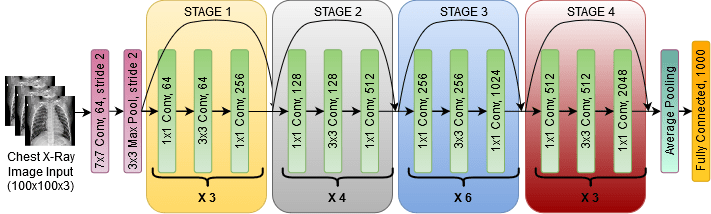


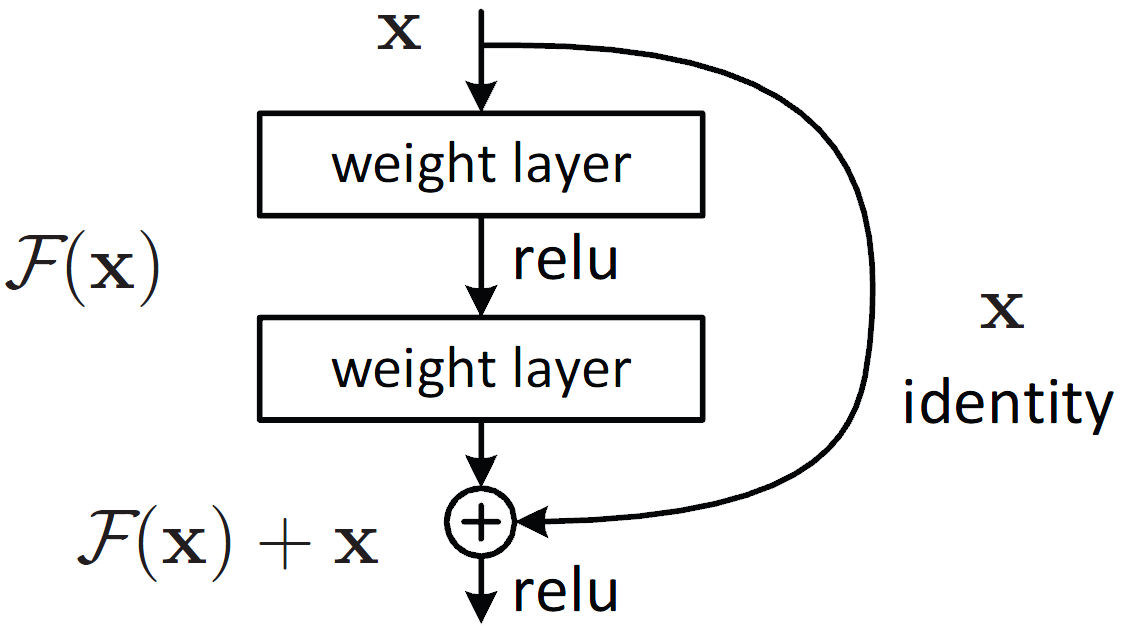

## Prepare dataset

In [2]:
import os
from kaggle.api.kaggle_api_extended import KaggleApi

os.environ['KAGGLE_USERNAME'] = "xxxxxx"                 #Manually input from kaggle
os.environ['KAGGLE_KEY'] = "xxxxxxx"   #Manually input from kaggle

api = KaggleApi()
api.authenticate()

api.dataset_download_files('misrakahmed/vegetable-image-dataset', path="./Images/", unzip=True)
del api

In [3]:
import random

path = './Images/Vegetable Images/'
classes = os.listdir(path + 'train/')

## ResNet Model

In [4]:
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten

from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt 
import glob

In [5]:
IMG_SIZE = [100,100]

resnet = ResNet50(input_shape = IMG_SIZE + [3], weights = 'imagenet', include_top = False)

#Disable training for existing weights
for layer in resnet.layers:
  layer.trainable = False

94765736/94765736 [==============================] - 46s 0us/step


In [6]:
resnet_output = Flatten()(resnet.output)
prediction = Dense(len(classes), activation = 'softmax')(resnet_output)


model = Model(inputs = resnet.input, outputs = prediction)

model.compile(loss = 'categorical_crossentropy', optimizer = 'rmsprop', metrics = ['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 106, 106, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 50, 50, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 50, 50, 64)   256         ['conv1_conv[0][0]']         

## Train the model

In [7]:
Train_img_generator = ImageDataGenerator(
    rotation_range = 20,       # Degree range for random rotations.
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.1,         # Shear Intensity (Shear angle in counter-clockwise direction in degrees)
    zoom_range = 0.2,          # Range for random zoom.
    horizontal_flip = True,    # Randomly flip inputs horizontally.
    vertical_flip = True,      # Randomly flip inputs vertically.
    preprocessing_function = preprocess_input
)

Validation_img_generator = ImageDataGenerator(
    preprocessing_function = preprocess_input
)

In [8]:
Train_generator = Train_img_generator.flow_from_directory(path + 'train/', target_size = IMG_SIZE)
Validate_generator = Validation_img_generator.flow_from_directory(path + 'validation/', target_size = IMG_SIZE)

Found 15000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.


In [9]:
Batch_size = 64
epochs = 10 

training_num_imgs = sum([len(os.listdir(path + 'train/' + label + '/')) for label in os.listdir(path + 'train/')])
val_num_imgs = sum([len(os.listdir(path + 'validation/' + label + '/')) for label in os.listdir(path + 'validation/')])

fitting = model.fit(Train_generator, 
                    validation_data = Validate_generator,
                    epochs = epochs,
                    steps_per_epoch = training_num_imgs//Batch_size ,
                    validation_steps = val_num_imgs//Batch_size)

Epoch 1/10
234/234 [==============================] - 22s 76ms/step - loss: 1.6225 - accuracy: 0.8596 - val_loss: 0.6098 - val_accuracy: 0.9436
Epoch 2/10
234/234 [==============================] - 17s 74ms/step - loss: 0.6692 - accuracy: 0.9398 - val_loss: 0.4800 - val_accuracy: 0.9633
Epoch 3/10
234/234 [==============================] - 17s 71ms/step - loss: 0.4557 - accuracy: 0.9579 - val_loss: 0.5037 - val_accuracy: 0.9660
Epoch 4/10
234/234 [==============================] - 17s 71ms/step - loss: 0.4678 - accuracy: 0.9676 - val_loss: 0.1928 - val_accuracy: 0.9878
Epoch 5/10
234/234 [==============================] - 16s 70ms/step - loss: 0.4322 - accuracy: 0.9673 - val_loss: 0.3588 - val_accuracy: 0.9762
Epoch 6/10
234/234 [==============================] - 17s 72ms/step - loss: 0.3803 - accuracy: 0.9717 - val_loss: 0.5131 - val_accuracy: 0.9708
Epoch 7/10
234/234 [==============================] - 17s 70ms/step - loss: 0.2906 - accuracy: 0.9761 - val_loss: 0.1481 - val_accuracy:

## Results

### Loss plot

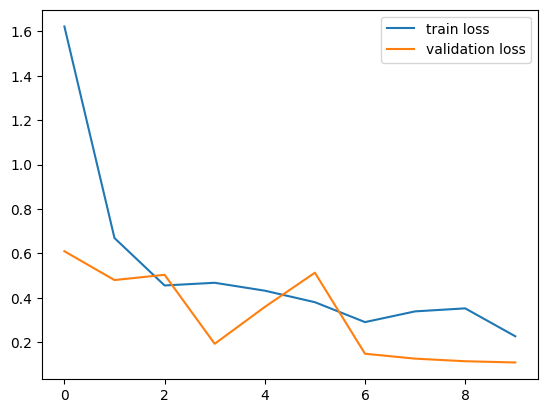

In [10]:
plt.plot(fitting.history['loss'], label = 'train loss')
plt.plot(fitting.history['val_loss'], label = 'validation loss')
plt.legend()

### Accuracy plot

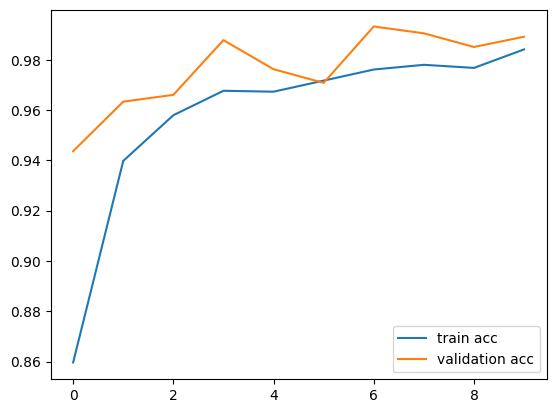

In [11]:
plt.plot(fitting.history['accuracy'], label = 'train acc')
plt.plot(fitting.history['val_accuracy'], label = 'validation acc')
plt.legend()

### Confusion matrix

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

def get_confusion_matrix(data_path, N):
  predictions = []
  targets = []

  for img, label in Validation_img_generator.flow_from_directory(data_path, target_size=IMG_SIZE, 
                                                 shuffle=False, batch_size=Batch_size * 2):
    prediction = model.predict(img, verbose = 0)
    p = np.argmax(prediction, axis=1)
    y = np.argmax(label, axis=1)

    predictions = np.concatenate((predictions, p))
    targets = np.concatenate((targets, y))

    if len(targets) >= N:
      break

  return confusion_matrix(targets, predictions)

labels = Train_generator.class_indices
labels = list(labels.keys())

Found 15000 images belonging to 15 classes.


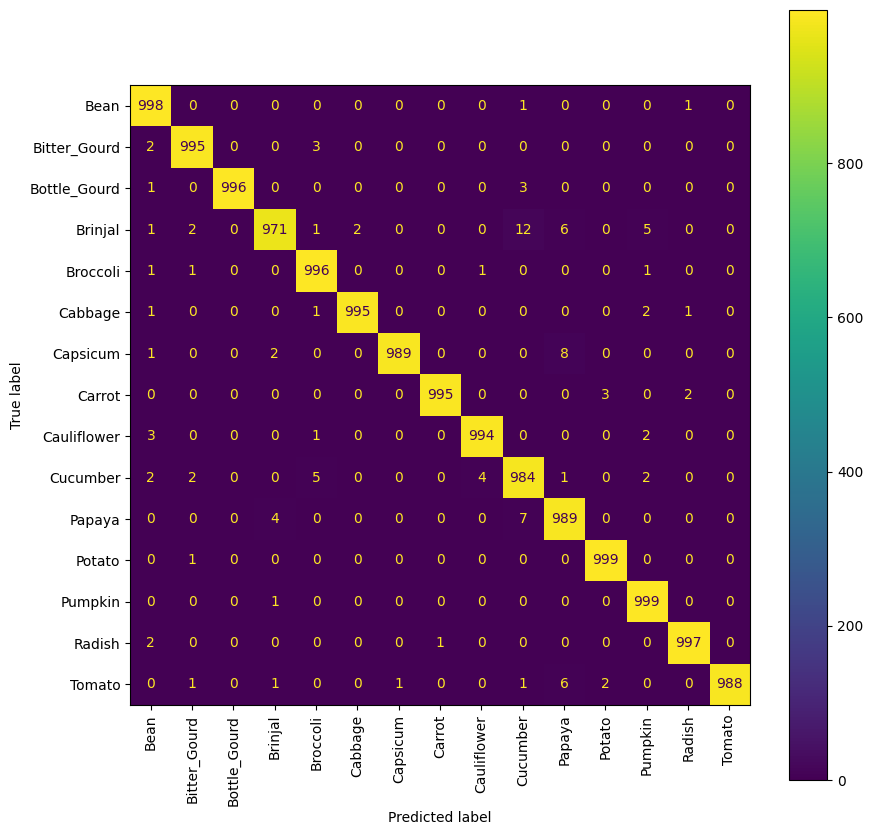

In [14]:
Training_conf_mx = get_confusion_matrix(path + 'train/', training_num_imgs)
disp = ConfusionMatrixDisplay(Training_conf_mx, display_labels=labels)
disp.plot(xticks_rotation = 90) 
disp.figure_.set_size_inches(10,10)

### Test

Found 3000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.


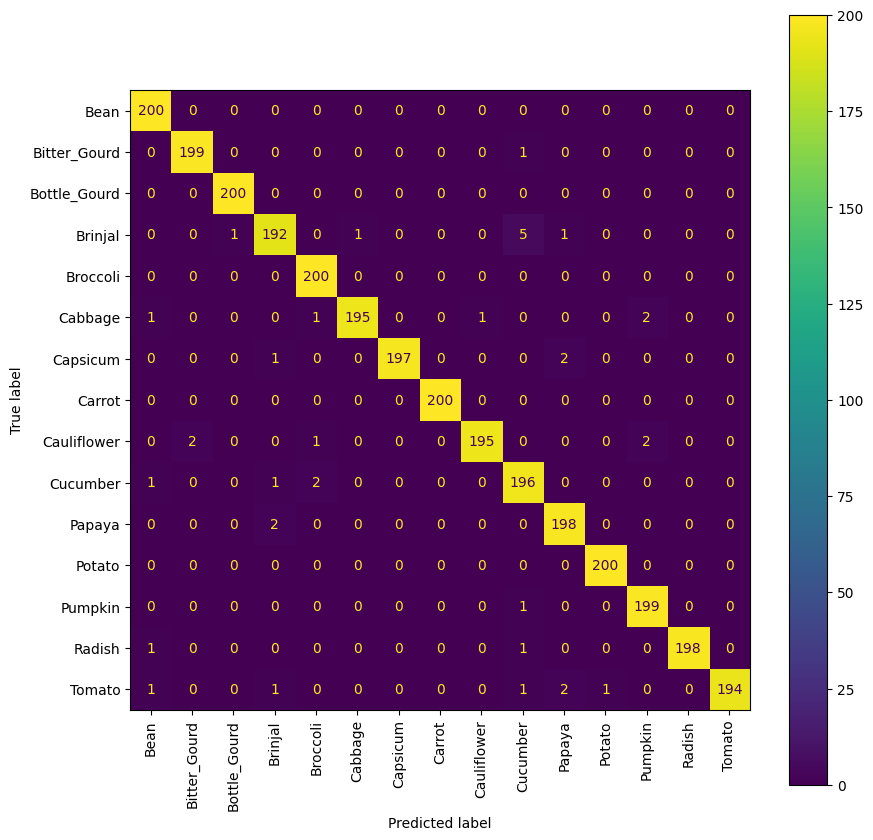

In [15]:
Test_generator = Validation_img_generator.flow_from_directory(path + 'test/', target_size = IMG_SIZE)
test_num_imgs = sum([len(os.listdir(path + 'test/' + label + '/')) for label in os.listdir(path + 'test/')])

Test_conf_mx = get_confusion_matrix(path + 'test/', test_num_imgs)
disp = ConfusionMatrixDisplay(Test_conf_mx, display_labels=labels)
disp.plot(xticks_rotation = 90) 
disp.figure_.set_size_inches(10,10)

Found 3000 images belonging to 15 classes.


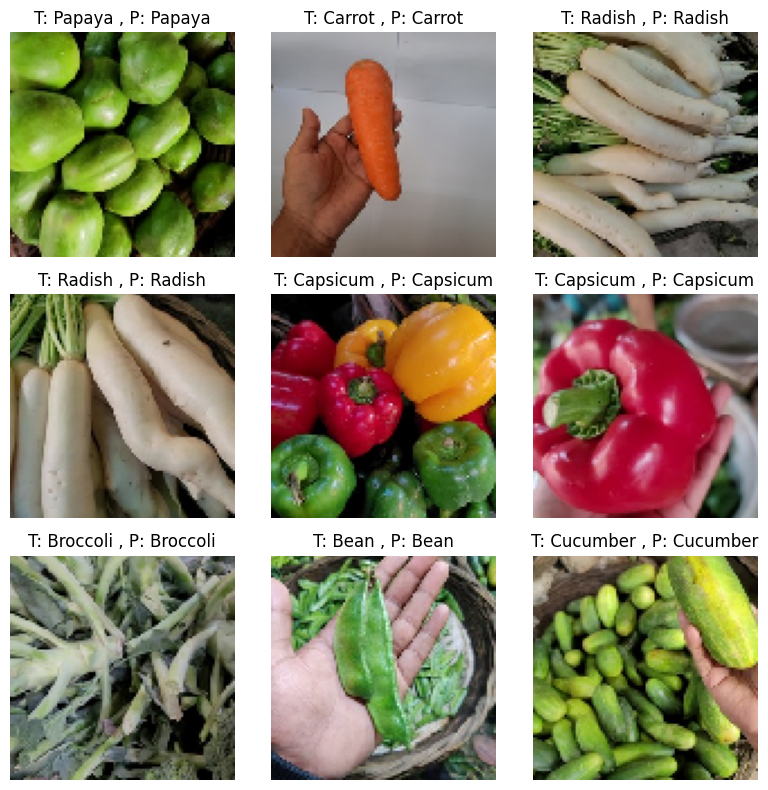

In [38]:
import cv2

fig, axs = plt.subplots(3,3)
fig.set_size_inches(8,8)

i = 0 
j = 0

for img, lbl in Validation_img_generator.flow_from_directory(path + 'test/', target_size=IMG_SIZE, shuffle=True, batch_size = 1, ):
  prediction = model.predict(img, verbose=0)

  mean = [103.939, 116.779, 123.68]
  
  img = np.squeeze(img, 0)

  img[:, :, 0] += mean[0]
  img[:, :, 1] += mean[1]
  img[:, :, 2] += mean[2]
  
  #BGR -> RGB
  img = img[:, :, ::-1]

  img = np.clip(img, 0, 255).astype('uint8')
  
  axs[i][j].imshow(img)
  axs[i][j].set_title('T: {} , P: {}'.format(classes[np.argmax(lbl)], classes[np.argmax(prediction)] ))
  axs[i][j].axis('off')

  j += 1
  if j > 2:
    i += 1
    if j > 2 and i > 2:
      break
    j = 0
  


fig.tight_layout()
    
